In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

x_train, y_train = readucr("Wafer_TRAIN.tsv")
x_test, y_test = readucr("Wafer_TEST.tsv")

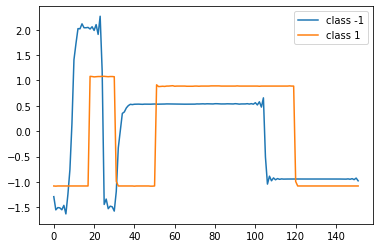

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Prepare the data


In [4]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [5]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [6]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [7]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

In [8]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    x = tf.keras.layers.LSTM(32, return_sequences=True)(input_layer)
    x = tf.keras.layers.LSTM(16)(x)
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])


## Train the model

In [9]:
epochs = 40
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
    ),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/40
155/155 [==============================] - 26s 127ms/step - loss: 0.5770 - sparse_categorical_accuracy: 0.7712 - val_loss: 0.4271 - val_sparse_categorical_accuracy: 0.8954 - lr: 1.0000e-04
Epoch 2/40
155/155 [==============================] - 20s 127ms/step - loss: 0.3604 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.3189 - val_sparse_categorical_accuracy: 0.8954 - lr: 1.0000e-04
Epoch 3/40
155/155 [==============================] - 17s 111ms/step - loss: 0.2936 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.2484 - val_sparse_categorical_accuracy: 0.8954 - lr: 1.0000e-04
Epoch 4/40
155/155 [==============================] - 17s 112ms/step - loss: 0.1989 - sparse_categorical_accuracy: 0.9020 - val_loss: 0.1552 - val_sparse_categorical_accuracy: 0.9132 - lr: 1.0000e-04
Epoch 5/40
155/155 [==============================] - 17s 113ms/step - loss: 0.1215 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.0979 - val_sparse_categorical_accuracy: 0.9781 - lr: 1.0000e-04


## Evaluate model on test data

In [10]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

32/32 [==============================] - 2s 30ms/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9940
Test accuracy 0.9940000176429749
Test loss 0.0244199987500906


## Plot the model's training and validation loss

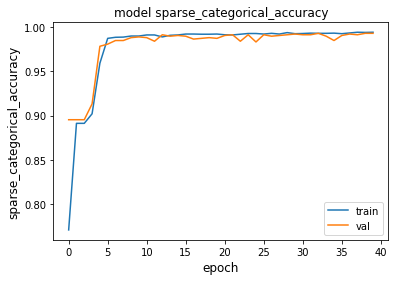

In [11]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()